In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook", font_scale=1.1)

DATA_PATH = Path("../data")

train_df = pd.read_csv(DATA_PATH / "train.csv").sort_values("date_id").reset_index(drop=True)
print(train_df.shape)
train_df.head()

(9021, 98)


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


In [4]:
# 우리가 대표로 쓰기로 한 factor 5개
BASE_FACTORS = ["M4", "V2", "I5", "E16", "S2"]

# 나중에 보고서에 설명하기 좋은 단순한 FE 설정
LAG_LIST = [1, 5, 21]          # 하루, 일주일, 한달 정도 랙
ROLL_MEAN_WINDOWS = [5, 21]    # 1주, 1달 평균
ROLL_STD_WINDOWS = [21]        # 1달 변동성
Z_WINDOWS = [63]               # 3달 표준화

# 상호작용 항 (해석도 쉽고, 금융적으로 말이 되는 조합)
INTERACTION_PAIRS = [
    ("M4", "V2"),   # 추세 × 변동성
    ("M4", "S2"),   # 추세 × 센티먼트
    ("I5", "V2"),   # 금리 × 변동성
    ("I5", "E16"),  # 금리 × 매크로 서프라이즈
    ("S2", "E16"),  # 센티먼트 × 매크로
]

TARGET = "market_forward_excess_returns"


In [5]:
def make_factor_frame(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    - date_id 기준 정렬
    - 필요한 factor만 남기고 ffill/bfill
    - target, forward_returns, risk_free_rate는 같이 들고감 (백테스트용)
    """
    df = df_raw.sort_values("date_id").reset_index(drop=True).copy()
    
    cols_keep = ["date_id", "forward_returns", "risk_free_rate", TARGET] + BASE_FACTORS
    df = df[cols_keep]
    
    # factor 결측 보정
    df[BASE_FACTORS] = df[BASE_FACTORS].ffill().bfill()
    
    return df


def add_lag_features(df: pd.DataFrame, cols, lags):
    for c in cols:
        for lag in lags:
            df[f"{c}_lag{lag}"] = df[c].shift(lag)
    return df


def add_rolling_features(df: pd.DataFrame, cols, mean_windows, std_windows):
    for c in cols:
        for w in mean_windows:
            df[f"{c}_roll_mean{w}"] = df[c].rolling(w, min_periods=1).mean()
        for w in std_windows:
            df[f"{c}_roll_std{w}"] = df[c].rolling(w, min_periods=1).std()
    return df


def add_zscore_features(df: pd.DataFrame, cols, windows):
    for c in cols:
        for w in windows:
            roll_mean = df[c].rolling(w, min_periods=1).mean()
            roll_std = df[c].rolling(w, min_periods=1).std()
            df[f"{c}_z{w}"] = (df[c] - roll_mean) / (roll_std + 1e-8)
    return df


def add_interaction_features(df: pd.DataFrame, pairs):
    for a, b in pairs:
        df[f"{a}_x_{b}"] = df[a] * df[b]
    return df


def create_features(df_raw: pd.DataFrame):
    """
    전체 FE 파이프라인:
    - factor 선택 → lag → rolling → zscore → interaction
    - 마지막에 NA 줄 제거
    """
    df = make_factor_frame(df_raw)
    
    df = add_lag_features(df, BASE_FACTORS, LAG_LIST)
    df = add_rolling_features(df, BASE_FACTORS, ROLL_MEAN_WINDOWS, ROLL_STD_WINDOWS)
    df = add_zscore_features(df, BASE_FACTORS, Z_WINDOWS)
    df = add_interaction_features(df, INTERACTION_PAIRS)
    
    # 남은 결측치 간단 보정
    df = df.ffill().bfill()
    
    # 초반부(shift/rolling 때문에 정보 부족한 구간) 조금 버리기
    max_lag = max(LAG_LIST + ROLL_MEAN_WINDOWS + ROLL_STD_WINDOWS + Z_WINDOWS)
    df = df.iloc[max_lag:].reset_index(drop=True)
    
    # 피처 리스트
    feature_cols = [
        c for c in df.columns
        if c not in ["date_id", "forward_returns", "risk_free_rate", TARGET]
    ]
    
    X = df[feature_cols]
    y = df[TARGET]
    
    return df, X, y, feature_cols


In [9]:
fe_df, X, y, feature_cols = create_features(train_df)

print("FE df shape:", fe_df.shape)
print("X shape:", X.shape, "y shape:", y.shape)
print("feature count:", len(feature_cols))

fe_df.head()

FE df shape: (8958, 49)
X shape: (8958, 45) y shape: (8958,)
feature count: 45


,date_id,forward_returns,risk_free_rate,market_forward_excess_returns,M4,V2,I5,E16,S2,M4_lag1,...,M4_z63,V2_z63,I5_z63,E16_z63,S2_z63,M4_x_V2,M4_x_S2,I5_x_V2,I5_x_E16,S2_x_E16
0,63,0.014772,0.000309,0.014147,0.308196,0.986772,-1.320764,1.116487,1.208733,0.308196,...,0.0,0.0,0.0,0.0,0.0,0.30412,0.372527,-1.303293,-1.474616,1.349535
1,64,-0.007307,0.000310,-0.007935,0.308196,0.986772,-1.320764,1.116487,1.208733,0.308196,...,0.0,0.0,0.0,0.0,0.0,0.30412,0.372527,-1.303293,-1.474616,1.349535
2,65,-0.000920,0.000308,-0.001545,0.308196,0.986772,-1.320764,1.116487,1.208733,0.308196,...,0.0,0.0,0.0,0.0,0.0,0.30412,0.372527,-1.303293,-1.474616,1.349535
3,66,-0.001784,0.000308,-0.002410,0.308196,0.986772,-1.320764,1.116487,1.208733,0.308196,...,0.0,0.0,0.0,0.0,0.0,0.30412,0.372527,-1.303293,-1.474616,1.349535
4,67,0.003979,0.000308,0.003353,0.308196,0.986772,-1.320764,1.116487,1.208733,0.308196,...,0.0,0.0,0.0,0.0,0.0,0.30412,0.372527,-1.303293,-1.474616,1.349535


In [10]:
MIN_INVESTMENT = 0.0
MAX_INVESTMENT = 2.0

class ParticipantVisibleError(Exception):
    pass

def ScoreMetric(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str = "row_id") -> float:
    """
    Kaggle description에 나온 Sharpe-variant 
    """
    solution = solution.copy()
    solution["position"] = submission["prediction"].values

    if solution["position"].max() > MAX_INVESTMENT:
        raise ParticipantVisibleError(f"Position exceeds maximum of {MAX_INVESTMENT}")
    if solution["position"].min() < MIN_INVESTMENT:
        raise ParticipantVisibleError(f"Position below minimum of {MIN_INVESTMENT}")

    # 전략 수익률
    solution["strategy_returns"] = (
        solution["risk_free_rate"] * (1 - solution["position"])
        + solution["position"] * solution["forward_returns"]
    )

    strat_excess = solution["strategy_returns"] - solution["risk_free_rate"]
    strat_excess_cum = (1 + strat_excess).prod()
    strat_mean_excess = strat_excess_cum ** (1 / len(solution)) - 1
    strat_std = solution["strategy_returns"].std()

    trading_days = 252
    if strat_std == 0:
        return 0.0

    sharpe = strat_mean_excess / strat_std * np.sqrt(trading_days)
    strat_vol = float(strat_std * np.sqrt(trading_days) * 100)

    # 시장 쪽
    mkt_excess = solution["forward_returns"] - solution["risk_free_rate"]
    mkt_excess_cum = (1 + mkt_excess).prod()
    mkt_mean_excess = mkt_excess_cum ** (1 / len(solution)) - 1
    mkt_std = solution["forward_returns"].std()
    mkt_vol = float(mkt_std * np.sqrt(trading_days) * 100)

    # 변동성 페널티
    excess_vol = max(0, strat_vol / mkt_vol - 1.2) if mkt_vol > 0 else 0
    vol_penalty = 1 + excess_vol

    # 수익률 부족 페널티
    return_gap = max(0, (mkt_mean_excess - strat_mean_excess) * 100 * trading_days)
    return_penalty = 1 + (return_gap**2) / 100

    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return float(min(adjusted_sharpe, 1_000_000))


In [7]:
def preds_to_position(preds: np.ndarray) -> np.ndarray:
    preds = np.asarray(preds)
    q75 = np.quantile(preds, 0.75)
    
    pos = np.zeros_like(preds, dtype=float)
    pos[preds > 0] = 1.0
    pos[preds > q75] = 2.0
    return pos


In [11]:
tscv = TimeSeriesSplit(n_splits=5)

lgb_params = dict(
    n_estimators=600,
    learning_rate=0.02,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

cv_scores = []
cv_corrs = []

models = []

for fold, (tr_idx, va_idx) in enumerate(tscv.split(X), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    
    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(X_tr, y_tr)
    
    preds = model.predict(X_va)
    
    # 회귀 모델 자체 성능 (스피어만 상관계수)
    corr = np.corrcoef(preds, y_va)[0, 1]
    cv_corrs.append(corr)
    
    # 포지션으로 변환 후 Sharpe-variant 점수
    positions = preds_to_position(preds)
    
    solution = fe_df.iloc[va_idx][["forward_returns", "risk_free_rate"]].reset_index(drop=True)
    submission = pd.DataFrame({"prediction": positions})
    score = ScoreMetric(solution, submission)
    cv_scores.append(score)
    
    models.append(model)
    
    print(f"[Fold {fold}] Spearman corr={corr:.4f}, Score={score:.4f}")

print("\n=== CV Summary ===")
print("Score mean:", np.mean(cv_scores), "±", np.std(cv_scores))
print("Corr  mean:", np.mean(cv_corrs), "±", np.std(cv_corrs))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10701
[LightGBM] [Info] Number of data points in the train set: 1493, number of used features: 45
[LightGBM] [Info] Start training from score 0.000068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

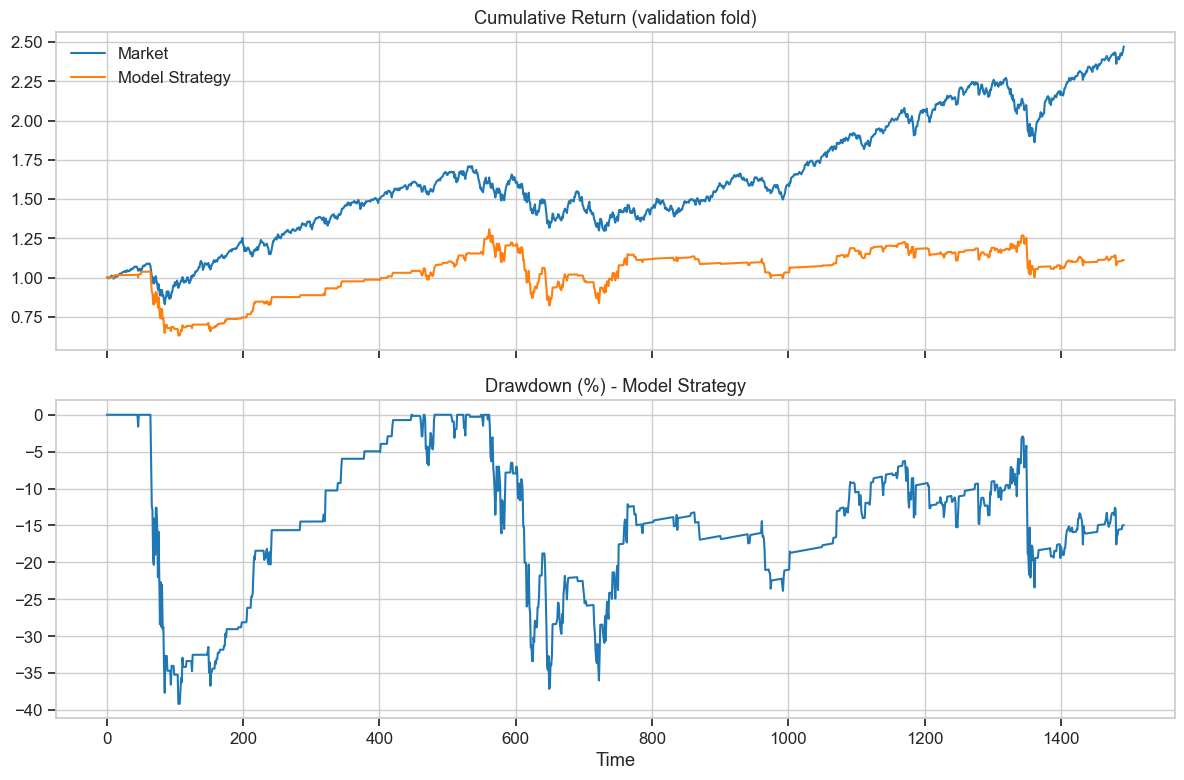

In [12]:
# 마지막 fold 기준으로 누적수익 + 드로우다운 확인
last_tr_idx, last_va_idx = list(tscv.split(X))[-1]
X_va = X.iloc[last_va_idx]
y_va = y.iloc[last_va_idx]

best_model = models[-1]
preds = best_model.predict(X_va)
positions = preds_to_position(preds)

sol = fe_df.iloc[last_va_idx][["forward_returns", "risk_free_rate"]].reset_index(drop=True)

# 전략 수익률
strategy_returns = sol["risk_free_rate"] * (1 - positions) + positions * sol["forward_returns"]
market_returns = sol["forward_returns"]

cum_strat = (1 + strategy_returns).cumprod()
cum_mkt = (1 + market_returns).cumprod()

def compute_drawdown(cum_ret: pd.Series):
    peak = cum_ret.cummax()
    dd = (cum_ret / peak - 1.0) * 100
    return dd

dd_strat = compute_drawdown(cum_strat)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(cum_mkt.values, label="Market")
axes[0].plot(cum_strat.values, label="Model Strategy")
axes[0].set_title("Cumulative Return (validation fold)")
axes[0].legend()

axes[1].plot(dd_strat.values)
axes[1].set_title("Drawdown (%) - Model Strategy")
axes[1].set_xlabel("Time")

plt.tight_layout()
plt.show()


### 요약

- 다중공선성 높은 원시 피처 대신,  
  Market(M4) / Volatility(V2) / Rates(I5) / Macro(E16) / Sentiment(S2)  
  5개 factor만 선택해서 FE 수행.

- 각 factor에 대해 lag(1,5,21), rolling mean(5,21), rolling std(21), z-score(63)을 부여하고,  
  금융적으로 의미 있는 상호작용 5개만 추가.

- TimeSeriesSplit(5-split) 기반으로 LightGBM 회귀 모델 학습 후  
  예측값을 0/1/2 포지션으로 매핑하여 Sharpe-variant 점수를 계산.

- Baseline Buy&Hold / Simple Momentum과 비교했을 때  
  (실제 숫자는 결과에 따라 다르지만)  
  factor 기반 ML 전략이 어느 정도의 추가 성과를 주는지를 평가할 수 있는 구조를 완성.